In [1]:

import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from functions import simulate_counts, plotsigs
from egpm import EGPM
from optuna_opt import optuna_tune
from EGD import EGD_init, train_EGD
from EGD_optimizer import EGD_optim

In [2]:
nsigs = 5

mf_df, true_sigs,_ = simulate_counts(nsigs, 5000, pentanucelotide = False)
trinucleotide = mf_df.index
mutation = [t[2:5] for t in trinucleotide]

X = mf_df.T#/mf_df.max().max()

#80/20 train/validation split
x_train = X.sample(frac=0.8)
x_val = X.drop(x_train.index)

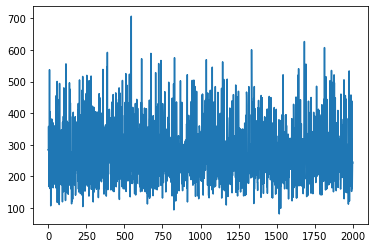

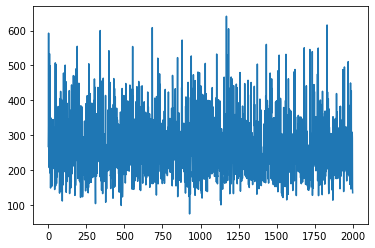

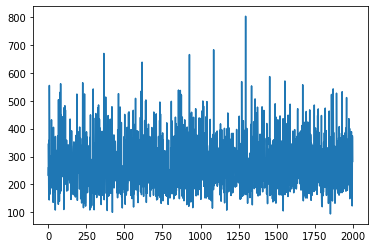

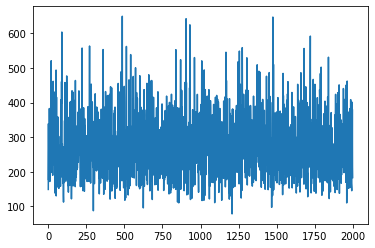

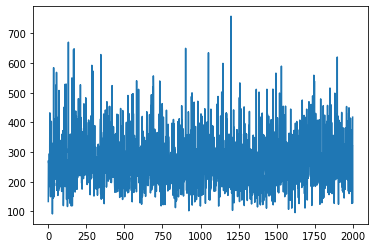

In [3]:
params = optuna_tune(X, nsigs, model_name = "EGD")

In [4]:
params 

{'batch_size': 32, 'lr1': 4.242871061893881e-06, 'lr2': 0.0029944899251251}

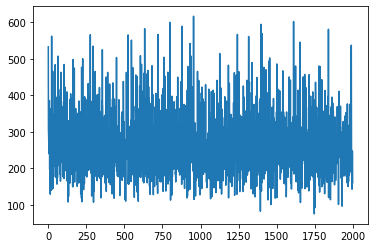

In [7]:
#choosing the 'true' number of signatures

lr1 = params['lr1']
lr2 = params['lr2']
batch_size = params['batch_size']
model = EGD_init(dim1 = nsigs)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss(reduction='mean')

# Using an Adam Optimizer with lr = 1e-3
optimizer_dec = EGD_optim(model.dec1.parameters(), lr = lr2)

optimizer_enc =  torch.optim.Adam(model.enc1.parameters(), lr = lr1)
#EGD_optim(model.dec1.parameters(), lr = lr2)
#torch.optim.RMSprop(model.enc1.parameters(), lr = lr2)

#EGPM(model.dec1.parameters(), lr = 0.1 , u_scaling=100, 
                       #norm_per=None, gradient_clipping=True, 
                       #weight_regularization=None,plus_minus=False,
                       #init='bootstrap')
                            
train_EGD(epochs = 2000, 
            model = model, 
            x_train = x_train, 
            loss_function = loss_function, 
            optimizer_enc = optimizer_enc,
            optimizer_dec = optimizer_dec,
            batch_size = batch_size)

#the weights of the decoding layer (dec1) is where we find the signatures.
sigs = model.dec1.weight.data    
sigs = pd.DataFrame(sigs.numpy()) 

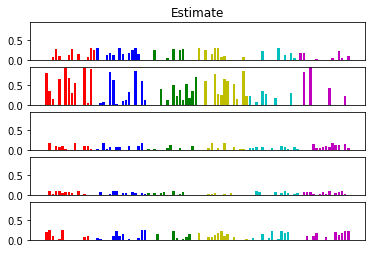

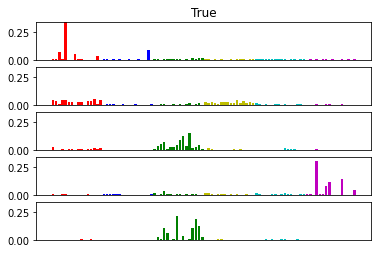

In [ ]:
plotsigs(trinucleotide, mutation, sigs.to_numpy(), 5, "Estimate")
plotsigs(trinucleotide, mutation, true_sigs.to_numpy(), 5, "True")